# Example 1: MAX-CUT with the CIM

This notebook serves as an introduction to utilizing the coherent Ising machine for MAX-CUT problems. The key goals are as follows:

* Brute force solving a simple MAX-CUT problem
* Solving a MAX-CUT problem with our CIM simulator
* Showcasing spin and energy evolutions of the CIM simulator.

The physical realization of the coherent Ising machine is a computing system that consists of numerous coupled optical parametric oscillators with increasing gain that aims to find the minimum energy of some Ising problem. 

Due to physical constraints, we simulate our CIM in Python to model its performance. This means that we attempt to compute the minimum of the energy function 

$$ H = -\sum_{1\leq i \leq j \leq N} J_{ij}\sigma_i \sigma_j - \sum_{1 \leq i \leq N} h_i \sigma_i$$

where we have an $N \times N$ matrix for $J$ (which is our spin coupling matrix) and an $N$-dimensional vector $h$ (which serves as our external field terms), along with each spin $\sigma_i \in \{ -1, 1\}$.  This means to leverage the CIM on some optimization problem requires converting it into an Ising problem where the solution to the problem is correlated with the ground state energy of the problem in Ising form. 

We provide three implementations of the CIM: chaotic amplitude control (CAC), amplitude-heterogeneity correction (AHC), and amplitude-heterogeneity correction with external field terms (AHC). The first two solvers do not have an external field, while the latter requires an external field $h$.

When the MAX-CUT problem is reformatted into an Ising problem, there is no external field, so either the CAC solver or the AHC no external field solver can be used. 

## Loading J matrix

The coupling matrices and bias vectors are stored as Numpy arrays, which could be loaded in from delimited files via the helper function load_matrix_from_rudy(), or from npz files.


In [1]:
#Initialization and Imports
import sys
from pathlib import Path
sys.path.append(str(Path.cwd()) + "\\..\\") # append repo to list of search directories 

from cim_optimizer.solve_Ising import *
from cim_optimizer.CIM_helper import brute_force

%matplotlib inline

In [2]:
instance_path_str_MAXCUT = str(Path.cwd()) + "\\..\\instances\\MC_Instances_NPZ\\"

# 20 spin MAXCUT problem
N = 20
mc_id = 1 # select first example of 20 spin MAXCUT problem
J = - np.load(instance_path_str_MAXCUT + f"MC50_N={N}_{mc_id}.npz") # load J matrix for 50% density MAX-CUT problem
gamma = 0.010 # set gamma hyperparameter

Note that we only modify the gamma hyperparameter since the default value for gamma (which is meant for MIRP problems) is too low for convergence towards the ground state energy.

## Brute force solving

We test every single possible spin configuration $\big($ i.e. $2^{20}$ configurations since each spin $\sigma_i \in \{ -1, 1\} \big)$, and return a tuple containing an array of the minimum spin configuration and ground state energy (lowest energy achieved).

In [3]:
spins_ground, E_ground = brute_force(J)

print("The spin configuration in the ground state is {}".format(spins_ground))
print("The ground energy is {}".format(E_ground))

The spin configuration in the ground state is [-1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1  1 -1]
The ground energy is -29.0


## Solving with the coherent Ising machine

We now apply the CAC CIM model to our J matrix for a single trial with default hyperparameters (with the exception of gamma). Our code returns certain pertinent metadata, including the target Ising energy, best Ising energy found and the corresponding spin configuration, time elapsed, number of trials, and success probability across the trials.

In [4]:
test = Ising(J).solve(cac_gamma=gamma)

1
No External Field Detected
Target Ising Energy: -inf.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [-1.  1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.
 -1. -1.].
Time Elapsed: 0.21691179275512695.
Number of Runs Completed: 1.


## Metadata and internal dynamics of the CIM

Various properties of the solver runs can be read from the attributes of the run result object, such as the time elapsed, best Ising energy reached by the CIM, as  well as trajectories of the spin amplitudes over time. Similarly, the evolution of the Ising energy corresponding to the spin amplitudes over time could be plotted by specifying the argument plot_type="energy". 

If the solve() function was called with multiple runs, and specific runs among them need to be plotted, the argument trajectories_to_plot=[] takes in a list of the desired run indices.


In [5]:
print("Time Elapsed: {} seconds".format(test.result.time))

Time Elapsed: 0.21691179275512695 seconds


In [6]:
print("Minimum Energy Achieved: {}".format(test.result.lowest_energy))

Minimum Energy Achieved: -29.0


In [7]:
np.set_printoptions(threshold=10, edgeitems=1)
print("Energy Evolution: {}".format(test.result.energy_evolution))
print("Spin Evolution: {}".format(test.result.spin_trajectories))

Energy Evolution: [array([ -5., ..., -29.], dtype=float32)]
Spin Evolution: [array([[ 4.3266034e-04, ..., -9.9718487e-01],
       ...,
       [ 6.5677159e-05, ..., -9.9468893e-01]], dtype=float32)]


The internal dynamics of both the spin amplitudes and energy evolution are included to showcase how our CIM evolves over discrete time steps.

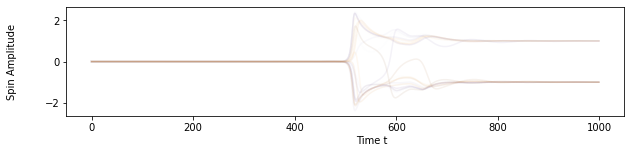

In [10]:
test.result.plot_spin_trajectories(plot_type="spins")

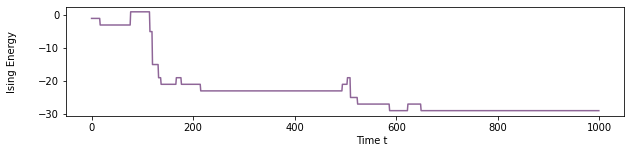

In [11]:
test.result.plot_spin_trajectories(plot_type="energy")

## GPU Acceleration

We now showcase our implementation with GPU acceleration using Pytorch and CUDA. While the speedup advantage is minor for smaller problems (such as an $N=20$ instance), the difference is more apparent at large spin counts. This is done by specifying the argument use_GPU=True, and requires a CUDA installation. By default, the argument use_GPU is set to False, and will run the solver in batches in parallel on the CPU.

In [4]:
test = Ising(J).solve(cac_gamma=gamma, use_GPU=True)

1
No External Field Detected
Target Ising Energy: -inf.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [ 1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1. -1.  1.  1.
  1.  1.].
Time Elapsed: 0.7019987106323242.
Number of Runs Completed: 1.
Success Probability: 0.0.


To specify the number of solver runs to be executed in parallel on a given device, the argument num_parallel_runs (set to 1 by default) can be modified. 

In [5]:
test = Ising(J).solve(cac_gamma=gamma, use_GPU=True, num_runs=5, num_parallel_runs=5)

1
No External Field Detected
Target Ising Energy: -inf.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [-1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1.  1.
  1. -1.].
Time Elapsed: 0.7505099773406982.
Number of Runs Completed: 5.
Success Probability: 0.0.


## Custom Ramp Schedules

The CIM-AHC, CIM-CAC solvers contain hyperparameters which could vary over the course of one solver run. To set an arbitrary feedback schedule, the arguments custom_feedback_schedule, custom_pump_schedule, and cac_amplitude_ramp can be specified with a specific anonymous function.

In [14]:
timestep_count = 1000
my_feedback_schedule = lambda x: np.sin(x/20)#torch.sin(torch.arange(timestep_count))
test = Ising(J).solve(cac_gamma=gamma, num_runs=5, num_timesteps_per_run = timestep_count, custom_feedback_schedule=my_feedback_schedule)

5
No External Field Detected
Target Ising Energy: -inf.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [1. ... 1.].
Time Elapsed: 1.0586538314819336.
Number of Runs Completed: 5.


## Setting a Target Energy

For benchmarking purposes, the ground-state Ising energy of inputted Ising problems can be specified to check whether the solver has reached it. This is modified via the target_energy argument.

In [18]:
timestep_count = 5000
ground_state_ising_energy = -29.0
my_feedback_schedule = lambda x: np.sin(x/33)
test = Ising(J).solve(cac_gamma=gamma, num_runs=5, target_energy=ground_state_ising_energy, num_timesteps_per_run = timestep_count, custom_feedback_schedule=my_feedback_schedule)

5
No External Field Detected
Target Ising Energy: -29.0.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [-1. ... -1.].
Time Elapsed: 5.439241170883179.
Number of Runs Completed: 5.
Success Probability: 1.0.
